## Doublets Examples

One for inhibitory, the other for excitatory

In [1]:
from pathlib import Path

import sys
import os
sys.path.append(os.path.abspath("../src"))

from utils import load_merfish_signal_df, load_banksy_result, load_merfish_data, load_boundaries_data

import anndata as ad
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

In [2]:
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Rectangle
from typing import Any
import matplotlib.lines as mlines

from matplotlib.colors import LinearSegmentedColormap

BIH_CMAP = LinearSegmentedColormap.from_list(
    "BIH",
    [
        "#430541",
        "mediumvioletred",
        "violet",
        "powderblue",
        "powderblue",
        "white",
        "white",
    ][::-1],
)

SCALEBAR_PARAMS: dict[str, Any] = {
    "dx": 1,
    "units": "um",
    "length_fraction": 0.1,
    "location": "lower right",
    "pad": 0.1,
    "frameon": False
}

def _plot_scalebar(ax, dx=1, units="um", fontsize=5, color="black", box_alpha=0, **kwargs):
    scalebar = ScaleBar(
        dx,
        units=units,
        scale_loc="top", 
        sep=1,
        **kwargs
    )
    scalebar.set_font_properties({"size": fontsize})
    scalebar.linewidth = 0.3
    scalebar.box_alpha = box_alpha
    scalebar.color = color
    ax.add_artist(scalebar)

### data

#### Signals in the Tissue Section

In [3]:
MERFISH_data_folder_path = Path("../data/mouse_hypothalamus/MERFISH/")

In [4]:
signal_coordinate_df, coordinate_x_m, coordinate_y_m = load_merfish_signal_df(MERFISH_data_folder_path/"merfish_barcodes_example.csv")

#### Results of BANKSY

In [5]:
banksy_folder_path = Path("../data/banksy_results/")

In [6]:
banksy_result = load_banksy_result(banksy_folder_path/"banksy_cluster.txt", coordinate_x_m, coordinate_y_m)

#### Segmentation Dataset

In [7]:
merfish_data = load_merfish_data(MERFISH_data_folder_path / "merfish_all_cells.csv", 
                                 banksy_result, coordinate_x_m, coordinate_y_m, 
                                 animal_id=1, bregma_value=-0.24)

#### Cell boundaries

In [8]:
boundaries_df = load_boundaries_data(MERFISH_data_folder_path/'cellboundaries_example_animal.csv', 
                                     merfish_data, coordinate_x_m, coordinate_y_m)

### Doublets

In [25]:
ovrlpy_result_folder = Path("../data/results/VSI/")

signal_integrity = np.loadtxt(ovrlpy_result_folder/"SignalIntegrity.txt")
signal_strength = np.loadtxt(ovrlpy_result_folder/"SignalStrength.txt")
pseudocells = ad.read_h5ad(ovrlpy_result_folder/"pseudocells.h5ad")
doublets = pl.read_csv(ovrlpy_result_folder/"doublets_df.csv")
windowsize = 60

#### UMAP

In [10]:
embedding = pseudocells.obsm["2D_UMAP"]
RGB = pseudocells.obsm["RGB"]

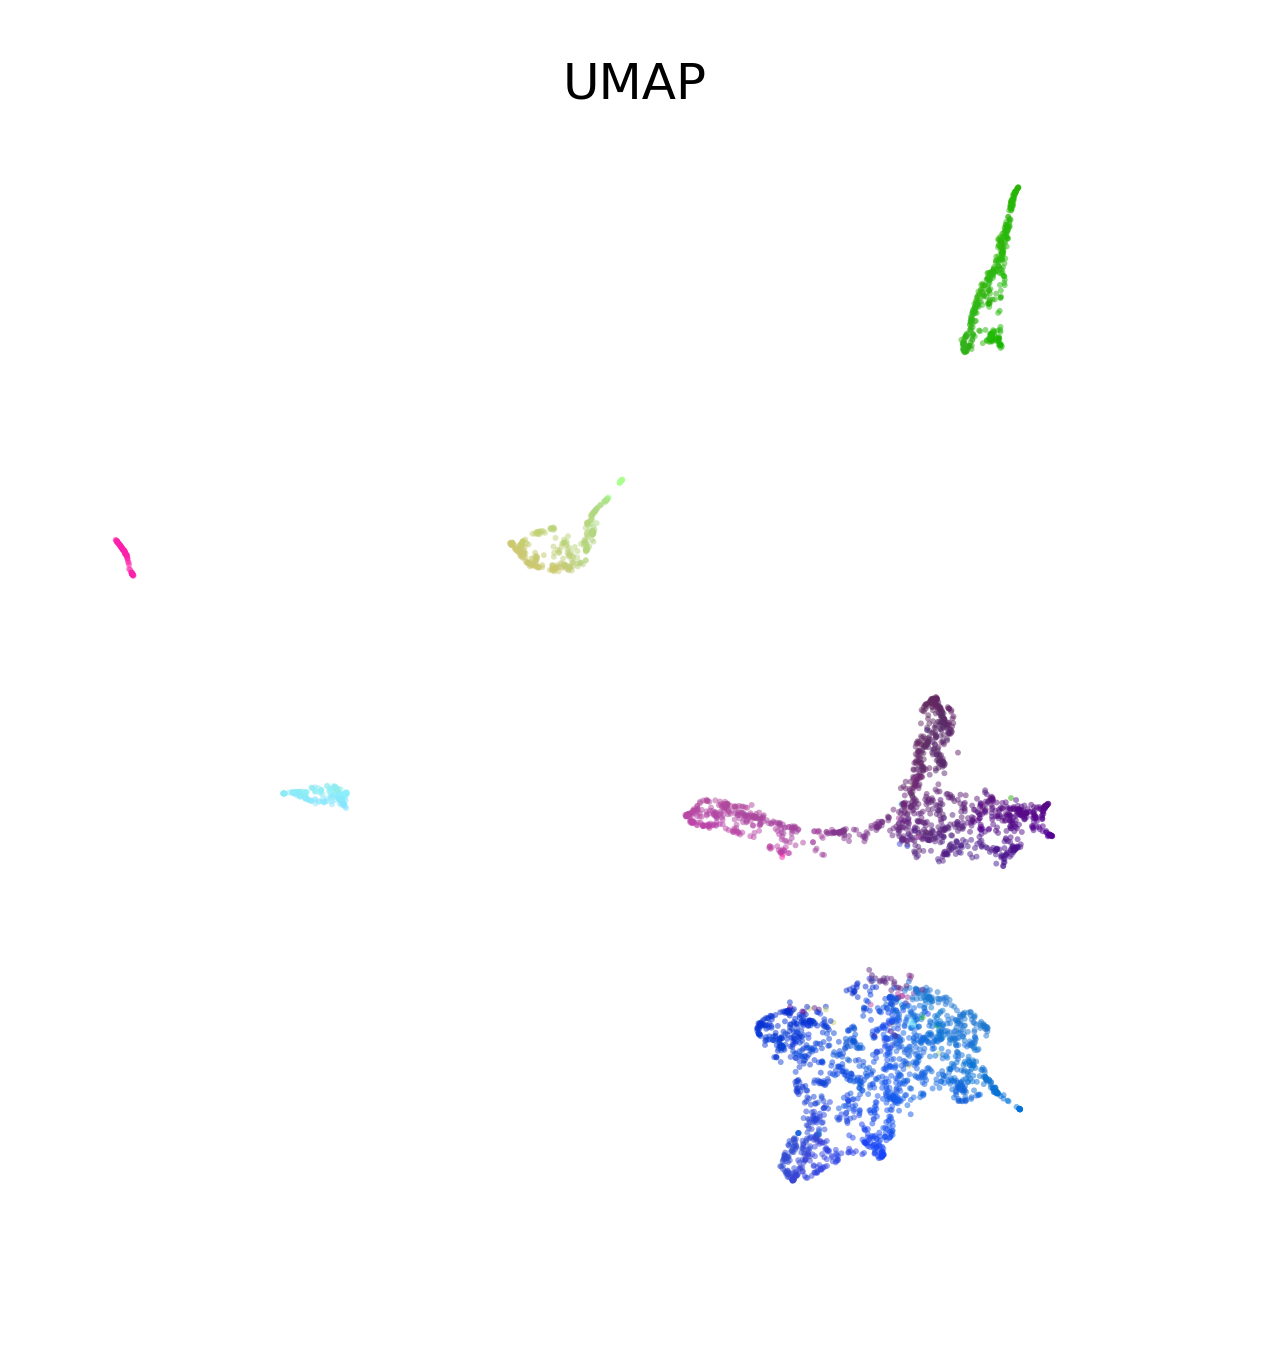

In [11]:
from typing import Any
scatter_kwargs: dict[str, Any] = {"alpha": 0.5, "marker": "."}

alpha = scatter_kwargs.pop("alpha", 0.5)
marker = scatter_kwargs.pop("marker", ".")

fig, ax = plt.subplots(figsize=(6/2.54, 6/2.54), dpi=600)
ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=RGB,
    alpha=alpha,
    marker=marker,
    edgecolors='none',
    s=2,
    # rasterized=True
)
ax.set(aspect='equal', adjustable='box')

ax.set_xlim(-8,17)
ax.set_ylim(-8,17)

# ax.spines['left'].set_linewidth(0.3)
# ax.spines['bottom'].set_linewidth(0.3)
# ax.spines['right'].set_linewidth(0.3)
# ax.spines['top'].set_linewidth(0.3)
ax.spines[["top", "right", "left", "bottom"]].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
plt.title("UMAP", fontsize=6)
plt.tight_layout()
plt.show()


#### Cell Map

In [12]:
spatial = pseudocells.obsm["spatial"]

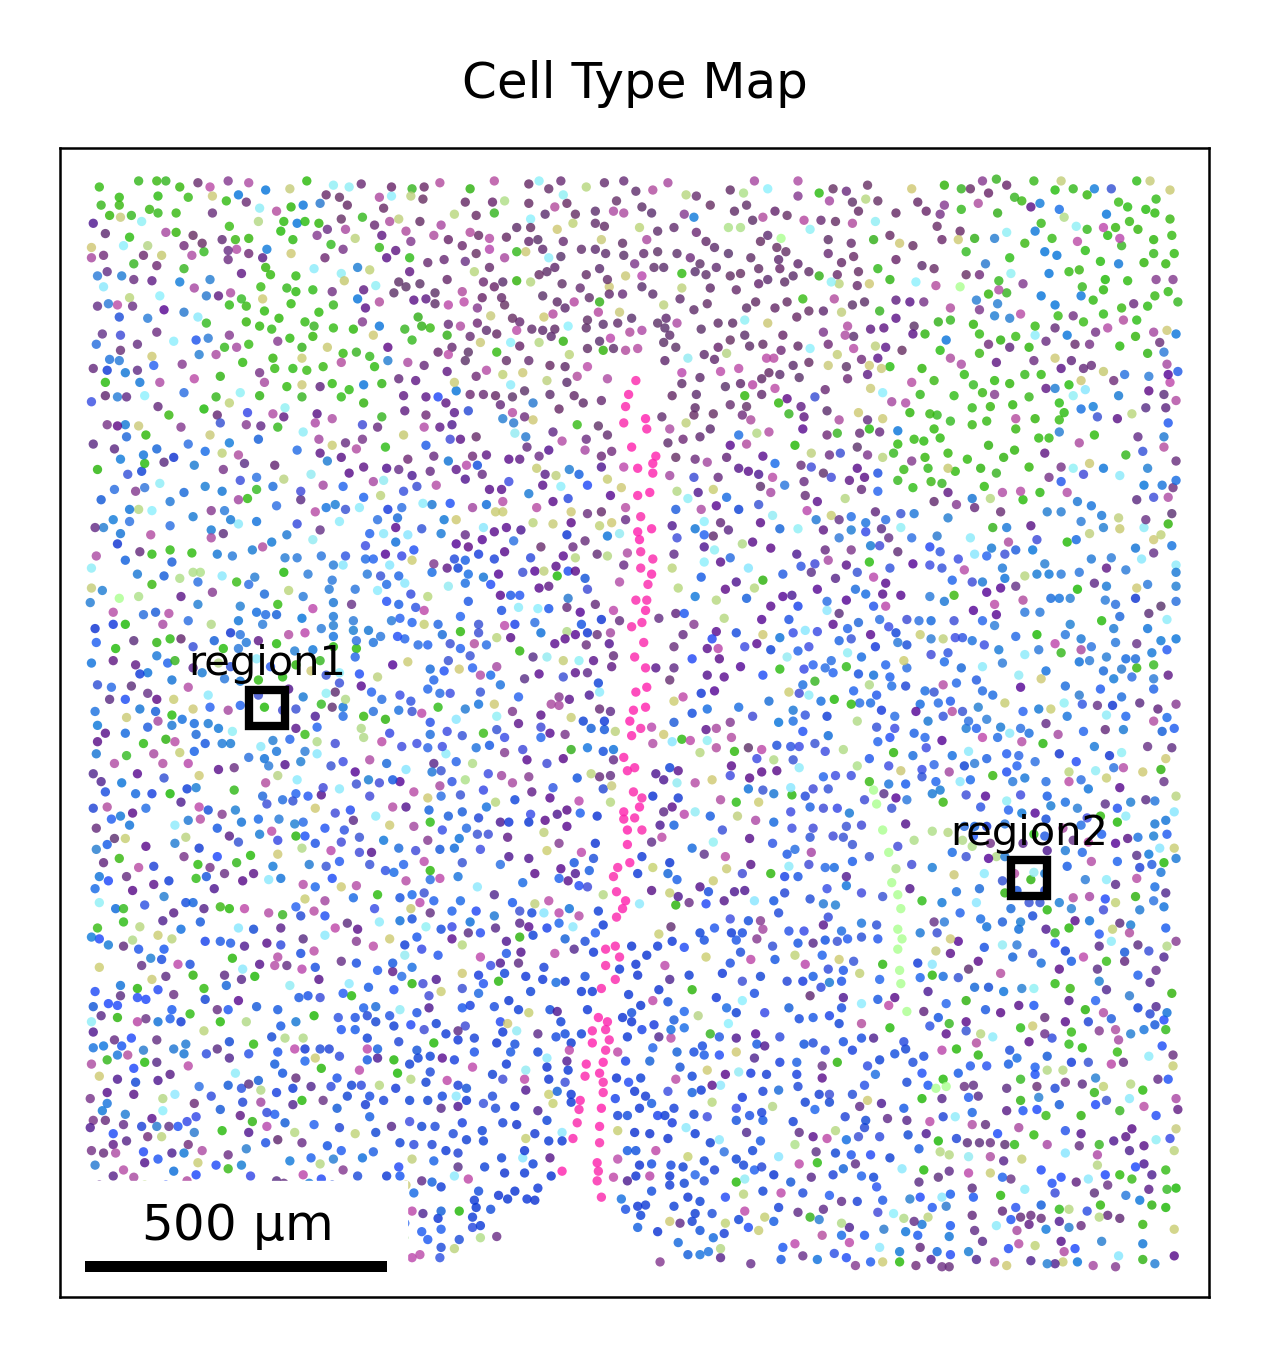

In [21]:
scatter_kwargs: dict[str, Any] = {"alpha": 0.8, "marker": "."}

alpha = scatter_kwargs.pop("alpha", 0.8)
marker = scatter_kwargs.pop("marker", ".")

fig, ax = plt.subplots(figsize=(6/2.54, 6/2.54), dpi=600)
ax.scatter(
    spatial[:, 0],
    spatial[:, 1],
    c=RGB,
    alpha=alpha,
    marker=marker,
    edgecolors='none',
    s=5,
    rasterized=True
)
ax.set(aspect="equal")
_plot_scalebar(ax, dx=1, units="um", location="lower left", length_fraction=0.3, fontsize=6, box_alpha=1)

doublet_to_show = 49
x_center, y_center = doublets["x", "y"].row(doublet_to_show)

x0 = x_center - windowsize / 2
y0 = y_center - windowsize / 2

square = Rectangle(
    (x0, y0),
    width=windowsize,
    height=windowsize,
    linewidth=1,
    fill=False,
    edgecolor="k",
)

ax.add_patch(square)
ax.text(x0 + windowsize / 2, y0+70, 'region1', ha='center', va='bottom', fontsize=5)

doublet_to_show = 158
x_center, y_center = doublets["x", "y"].row(doublet_to_show)

x0 = x_center - windowsize / 2
y0 = y_center - windowsize / 2

square = Rectangle(
    (x0, y0),
    width=windowsize,
    height=windowsize,
    linewidth=1,
    fill=False,
    edgecolor="k",
)

ax.add_patch(square)
ax.text(x0 + windowsize / 2, y0 + 70, 'region2', ha='center', va='bottom', fontsize=5)

ax.set_xticks([])
ax.set_yticks([])
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_linewidth(0.3)
ax.spines['right'].set_linewidth(0.3)
ax.spines['top'].set_linewidth(0.3)
ax.set_xlim(-50,1850)
ax.set_ylim(-50,1850)
ax.set_aspect('equal')
plt.title("Cell Type Map", fontsize=6)
plt.tight_layout()
plt.show()


#### Doublet1: Inhibitory

doublet_to_show = 49  
x,y = 292, 924

In [22]:
window_size = windowsize / 2

In [23]:
doublet_to_show = 49
x, y = doublets["x", "y"].row(doublet_to_show)
roi = ((x - window_size, x + window_size), (y - window_size, y + window_size))

In [24]:
ROI_in = pl.read_parquet(ovrlpy_result_folder/"roi_transcripts_In.parquet")

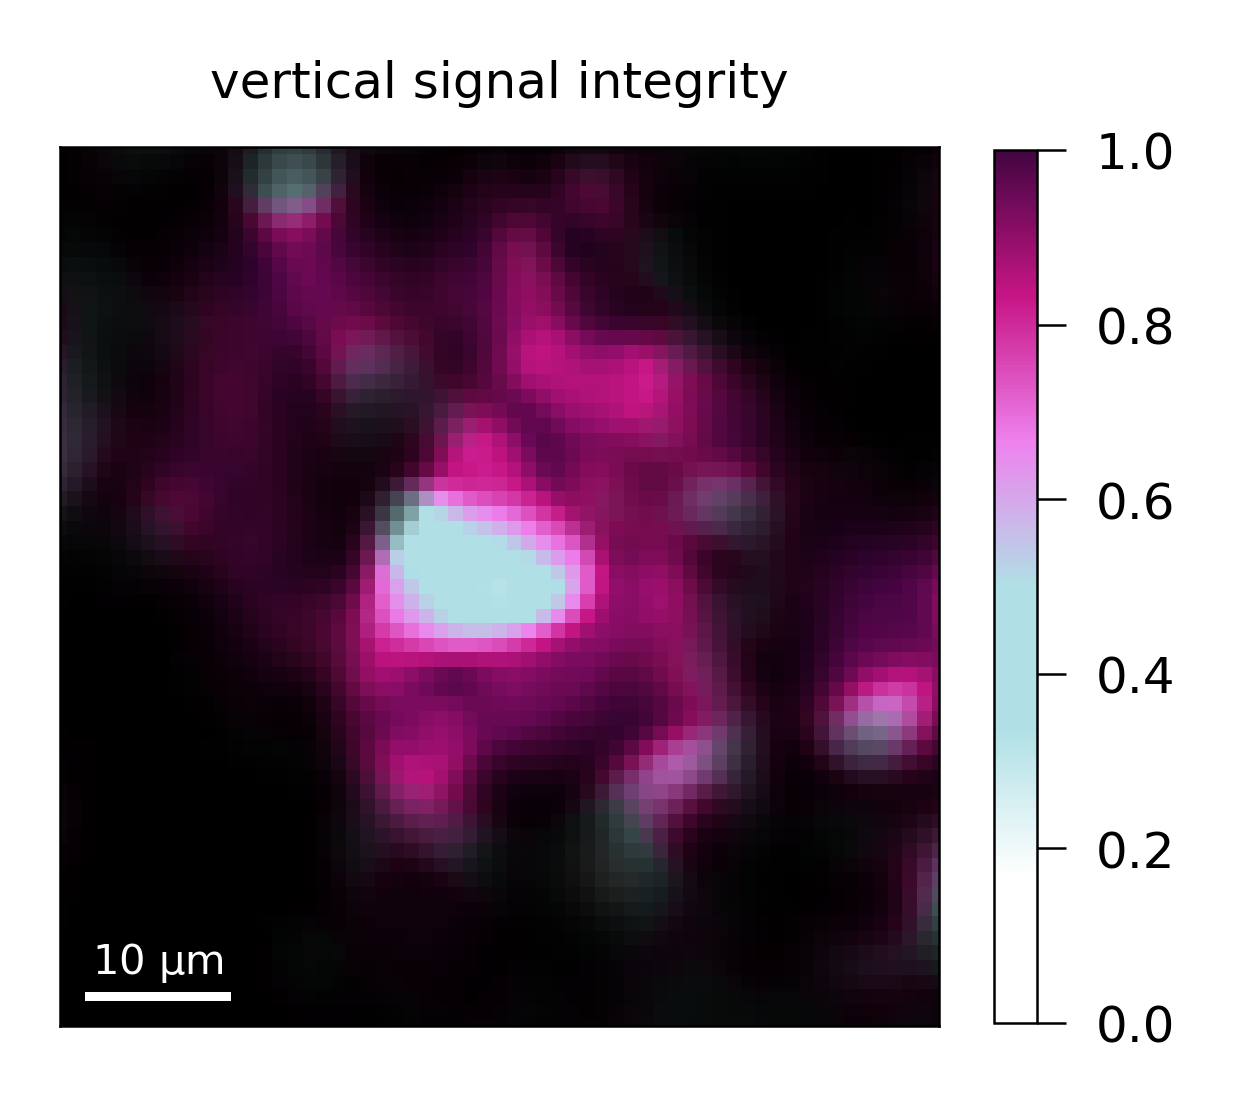

In [ ]:
cell_integrity = signal_integrity
cell_strength = signal_strength
signal_threshold=3.0
figure_height=6/2.54
cmap = BIH_CMAP


fig, ax = plt.subplots(
            1, 1,
            figsize=(figure_height, figure_height),
            dpi=600
        )
ax = [ax]
ax[0].set_facecolor("black")
    # Main heatmap
img = ax[0].imshow(
        cell_integrity,
        cmap=cmap,
        alpha=((cell_strength / signal_threshold).clip(0, 1) ** 2),
        vmin=0,
        vmax=1,
        rasterized=True
    )
ax[0].invert_yaxis()
    # ax[0].spines[["top", "right"]].set_visible(False)
# ax[0].spines[["top", "right", "left", "bottom"]].set_visible(False)
ax[0].spines[["top", "right", "left", "bottom"]].set_linewidth(0.3)

ax[0].spines['left'].set_linewidth(0.3)
ax[0].spines['bottom'].set_linewidth(0.3)

# ax[0].scatter(x, y, c="k", marker="+", s=17)
ax[0].set(xlim=roi[0], ylim=roi[1])

cbar = fig.colorbar(img, ax=ax[0], shrink=0.8)
cbar.ax.tick_params(labelsize=6, width=0.3)
for spine in cbar.ax.spines.values():
    spine.set_linewidth(0.3) 
_plot_scalebar(ax[0], dx=1, units="um", location="lower left", length_fraction=0.2, fontsize=5, color="white")


ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("vertical signal integrity", fontsize=6)
ax[0].set_aspect('equal')
x_min, x_max = roi[0]
y_min, y_max = roi[1]
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

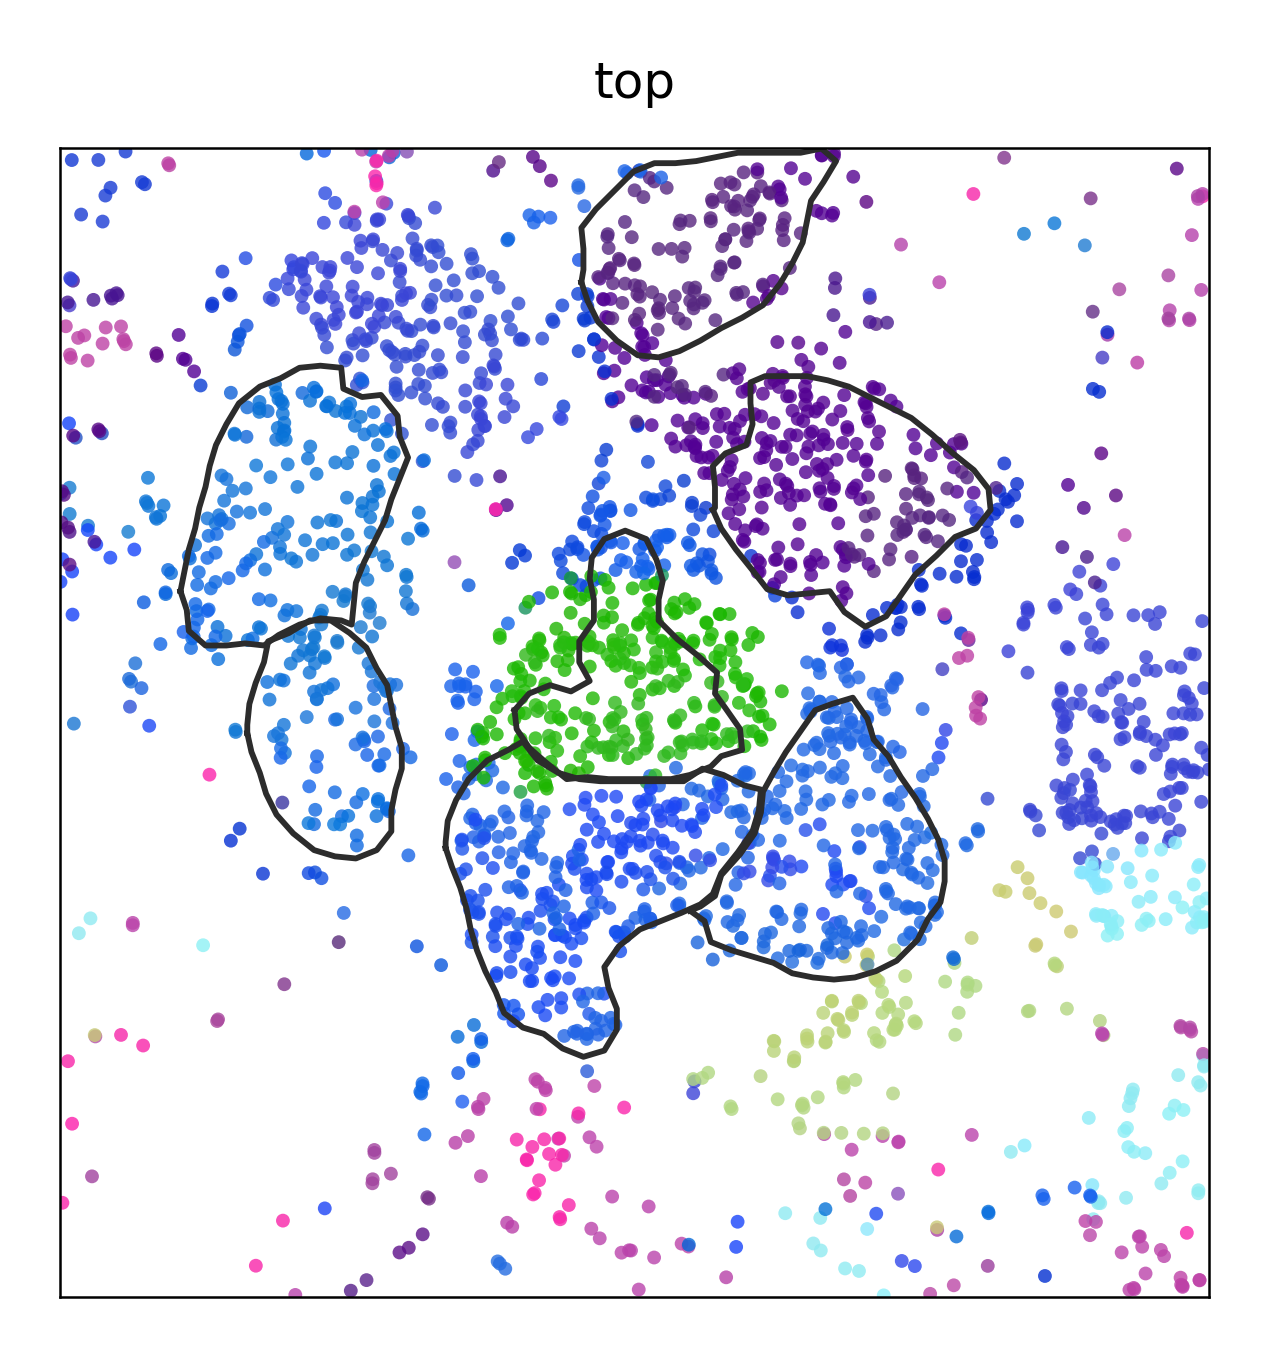

In [35]:
scalebar = SCALEBAR_PARAMS
roi_scatter_kwargs = dict(marker=".", alpha=0.8, s=11)

roi_top = ROI_in.filter(pl.col("z") > pl.col("z_center"))
fig, ax = plt.subplots(figsize=(6/2.54, 6/2.54), dpi=600)
ax.scatter(
    roi_top["x"],
    roi_top["y"],
    c=roi_top["RGB"].to_numpy(),
    **roi_scatter_kwargs,
    edgecolors='none',
    rasterized=True
)
# ax.scatter(x, y, c="k", marker="+", s=17)
ax.set(xlim=roi[0], ylim=roi[1])

# _plot_scalebar(ax, dx=1, units="um", location="upper right", length_fraction=0.2, fontsize=6)

x_min, x_max = roi[0]
y_min, y_max = roi[1]

filtered_df = boundaries_df[
    (boundaries_df['x'] >= x_min) & (boundaries_df['x'] <= x_max) &
    (boundaries_df['y'] >= y_min) & (boundaries_df['y'] <= y_max)
]

for _, row in filtered_df.iterrows():
    ax.plot(row['boundaryX'], row['boundaryY'],
               c='#2C2C2C', linewidth=0.7)
    ax.spines[["top", "right"]].set_visible(True)

ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_linewidth(0.3)
ax.spines['right'].set_linewidth(0.3)
ax.spines['top'].set_linewidth(0.3)
plt.title("top", fontsize=6)
plt.tight_layout()  
plt.show()


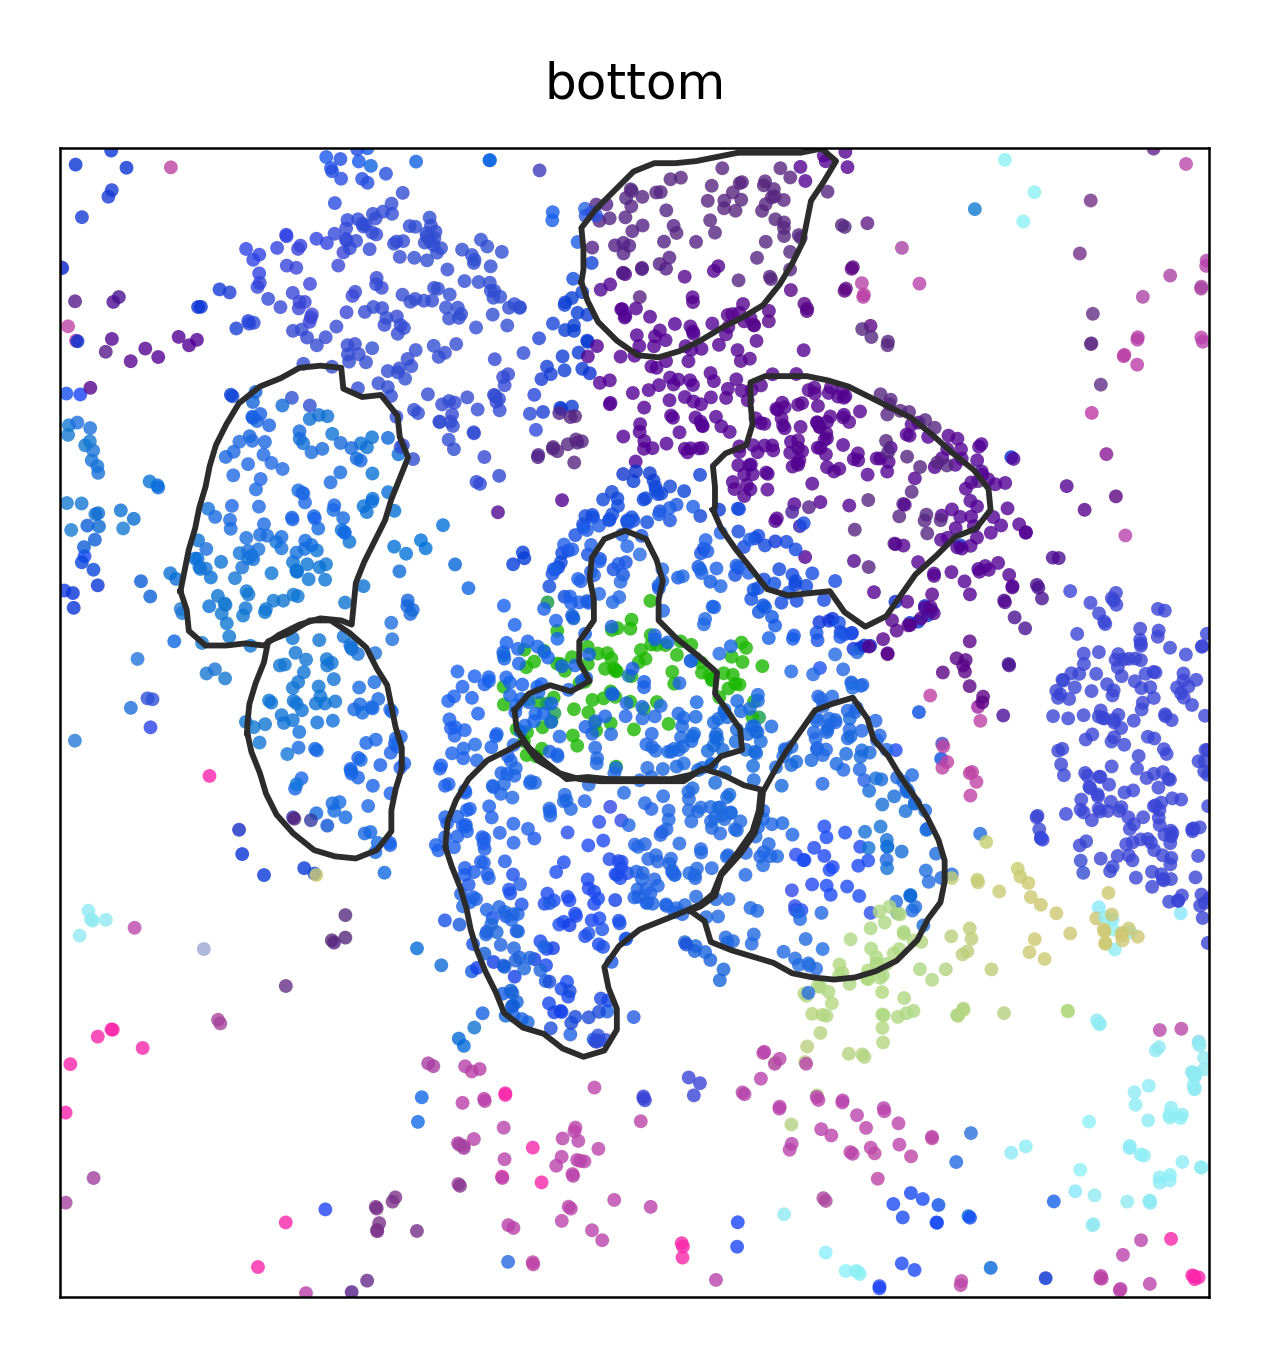

In [37]:
scalebar = SCALEBAR_PARAMS
roi_scatter_kwargs = dict(marker=".", alpha=0.8, s=11)

roi_bottom = ROI_in.filter(pl.col("z") < pl.col("z_center"))[::-1]
fig, ax = plt.subplots(figsize=(6/2.54, 6/2.54), dpi=600)
ax.scatter(
    roi_bottom["x"],
    roi_bottom["y"],
    c=roi_bottom["RGB"].to_numpy(),
    **roi_scatter_kwargs,
    edgecolors='none',
    rasterized=True
)
# ax.scatter(x, y, c="k", marker="+", s=17)
ax.set(xlim=roi[0], ylim=roi[1])

# _plot_scalebar(ax, dx=1, units="um", location="upper right", length_fraction=0.2, fontsize=6)

x_min, x_max = roi[0]
y_min, y_max = roi[1]

filtered_df = boundaries_df[
    (boundaries_df['x'] >= x_min) & (boundaries_df['x'] <= x_max) &
    (boundaries_df['y'] >= y_min) & (boundaries_df['y'] <= y_max)
]

for _, row in filtered_df.iterrows():
    ax.plot(row['boundaryX'], row['boundaryY'],
               c='#2C2C2C', linewidth=0.7)
    ax.spines[["top", "right"]].set_visible(True)

ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_linewidth(0.3)
ax.spines['right'].set_linewidth(0.3)
ax.spines['top'].set_linewidth(0.3)
plt.title("bottom", fontsize=6)
plt.tight_layout()  
plt.show()


#### Doublet2: Excitatory

doublet_to_show = 158  

In [38]:
ROI_ex =pl.read_parquet(ovrlpy_result_folder/"roi_transcripts_Ex.parquet")

doublet_to_show = 158
x, y = doublets["x", "y"].row(doublet_to_show)
roi = ((x - window_size, x + window_size), (y - window_size, y + window_size))

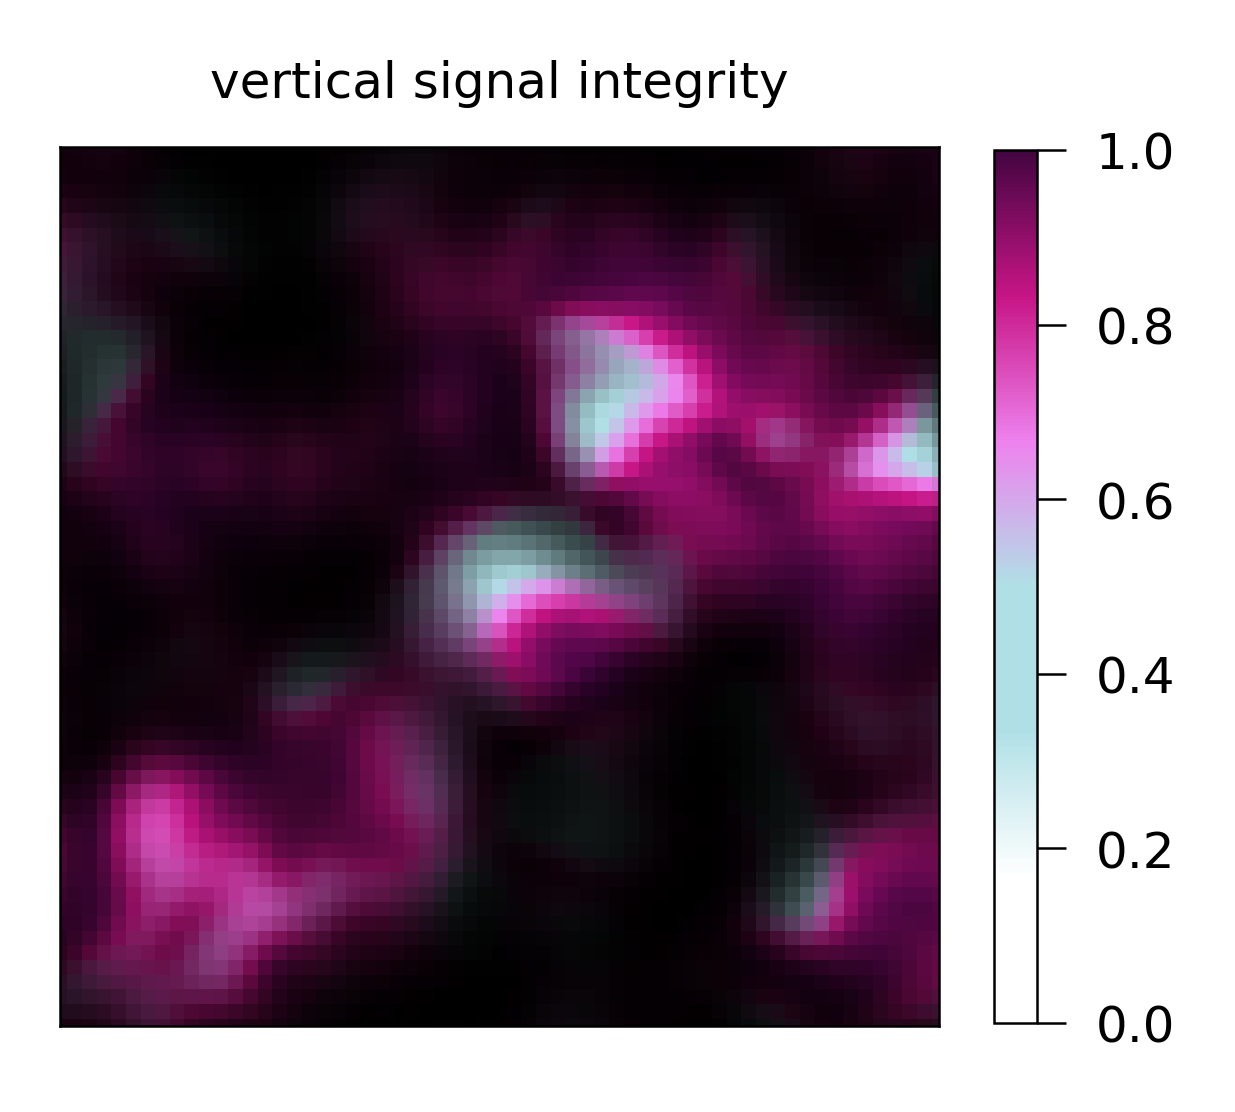

In [41]:
cell_integrity = signal_integrity
cell_strength = signal_strength
signal_threshold=3.0
figure_height=6/2.54
cmap = BIH_CMAP


fig, ax = plt.subplots(
            1, 1,
            figsize=(figure_height, figure_height),
            dpi=600
        )
ax = [ax]
ax[0].set_facecolor("black")
    # Main heatmap
img = ax[0].imshow(
        cell_integrity,
        cmap=cmap,
        alpha=((cell_strength / signal_threshold).clip(0, 1) ** 2),
        vmin=0,
        vmax=1,
        rasterized=True
    )
ax[0].invert_yaxis()
    # ax[0].spines[["top", "right"]].set_visible(False)
# ax[0].spines[["top", "right", "left", "bottom"]].set_visible(False)
ax[0].spines[["top", "right", "left", "bottom"]].set_linewidth(0.3)

ax[0].spines['left'].set_linewidth(0.3)
ax[0].spines['bottom'].set_linewidth(0.3)

# ax[0].scatter(x, y, c="k", marker="+", s=17)
ax[0].set(xlim=roi[0], ylim=roi[1])

cbar = fig.colorbar(img, ax=ax[0], shrink=0.8)
cbar.ax.tick_params(labelsize=6, width=0.3)
for spine in cbar.ax.spines.values():
    spine.set_linewidth(0.3) 


ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("vertical signal integrity", fontsize=6)
ax[0].set_aspect('equal')
x_min, x_max = roi[0]
y_min, y_max = roi[1]

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

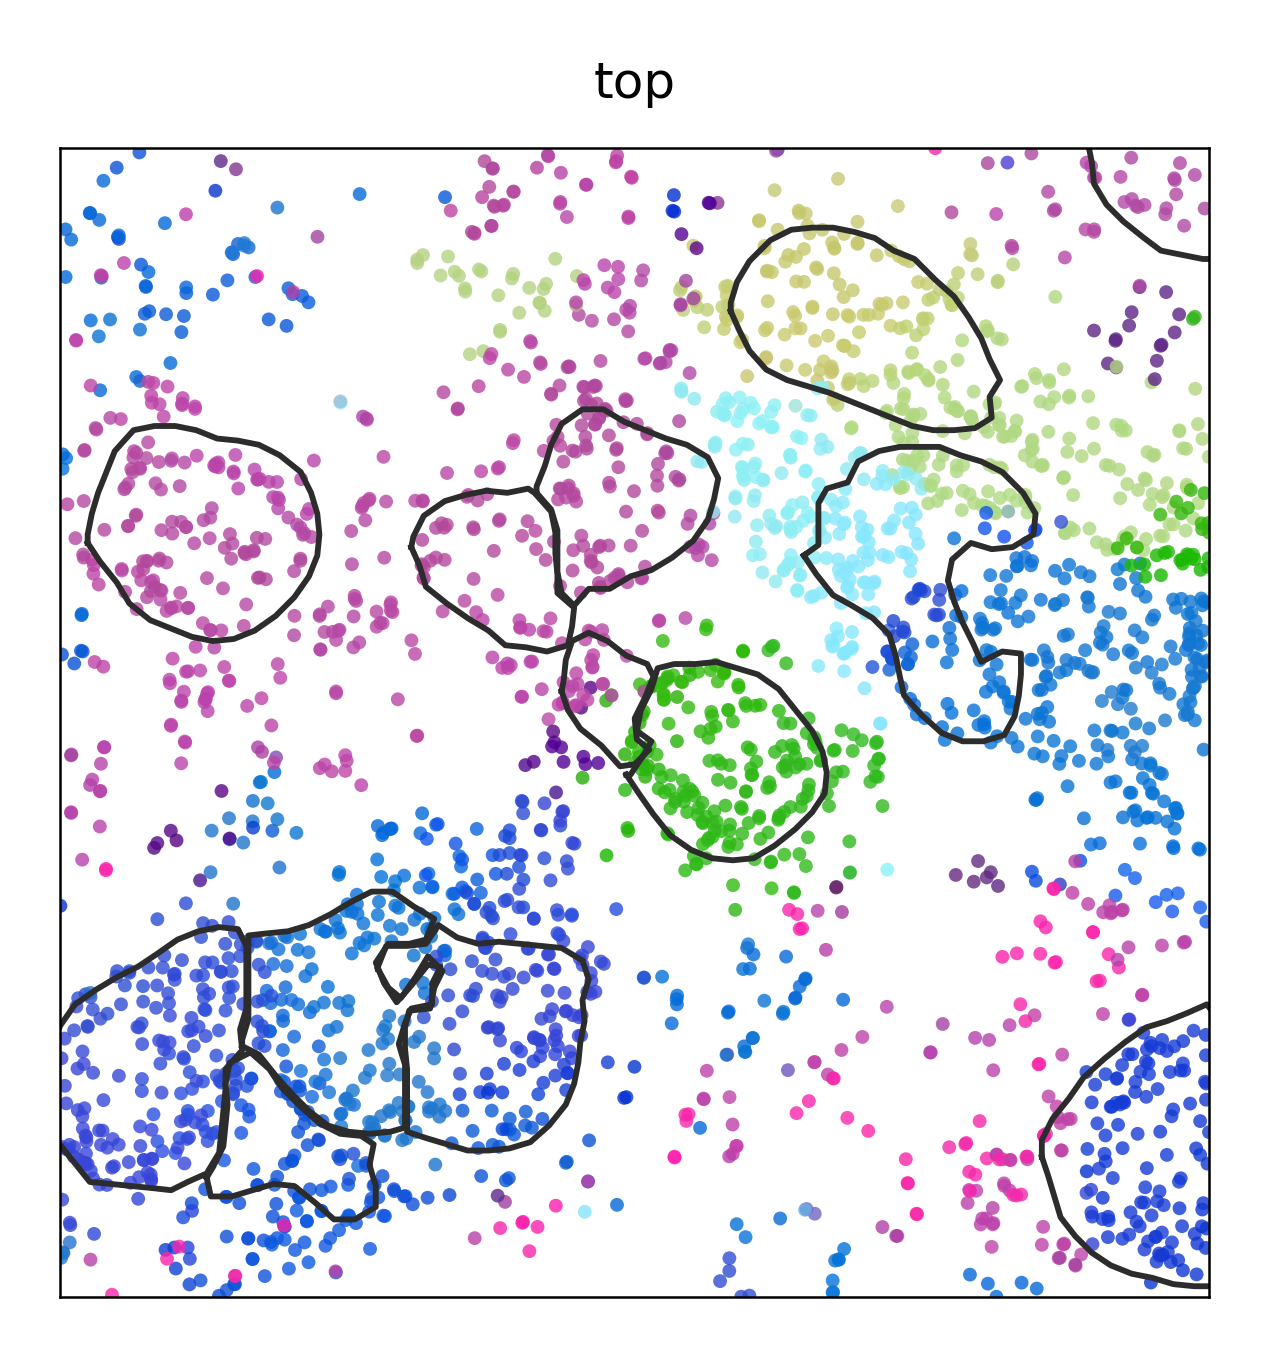

In [43]:
scalebar = SCALEBAR_PARAMS
roi_scatter_kwargs = dict(marker=".", alpha=0.8, s=11)

roi_top = ROI_ex.filter(pl.col("z") > pl.col("z_center"))
fig, ax = plt.subplots(figsize=(6/2.54, 6/2.54), dpi=600)
ax.scatter(
    roi_top["x"],
    roi_top["y"],
    c=roi_top["RGB"].to_numpy(),
    **roi_scatter_kwargs,
    edgecolors='none',
    rasterized=True
)

# _plot_scalebar(ax, dx=1, units="um", location="upper right", length_fraction=0.2, fontsize=6)

x_min, x_max = roi[0]
y_min, y_max = roi[1]

filtered_df = boundaries_df[
    (boundaries_df['x'] >= x_min) & (boundaries_df['x'] <= x_max) &
    (boundaries_df['y'] >= y_min) & (boundaries_df['y'] <= y_max)
]

for _, row in filtered_df.iterrows():
    ax.plot(row['boundaryX'], row['boundaryY'],
               c='#2C2C2C', linewidth=0.7)
    ax.spines[["top", "right"]].set_visible(True)

ax.set(xlim=roi[0], ylim=roi[1])

ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_linewidth(0.3)
ax.spines['right'].set_linewidth(0.3)
ax.spines['top'].set_linewidth(0.3)
plt.title("top", fontsize=6)
plt.tight_layout()  
plt.show()


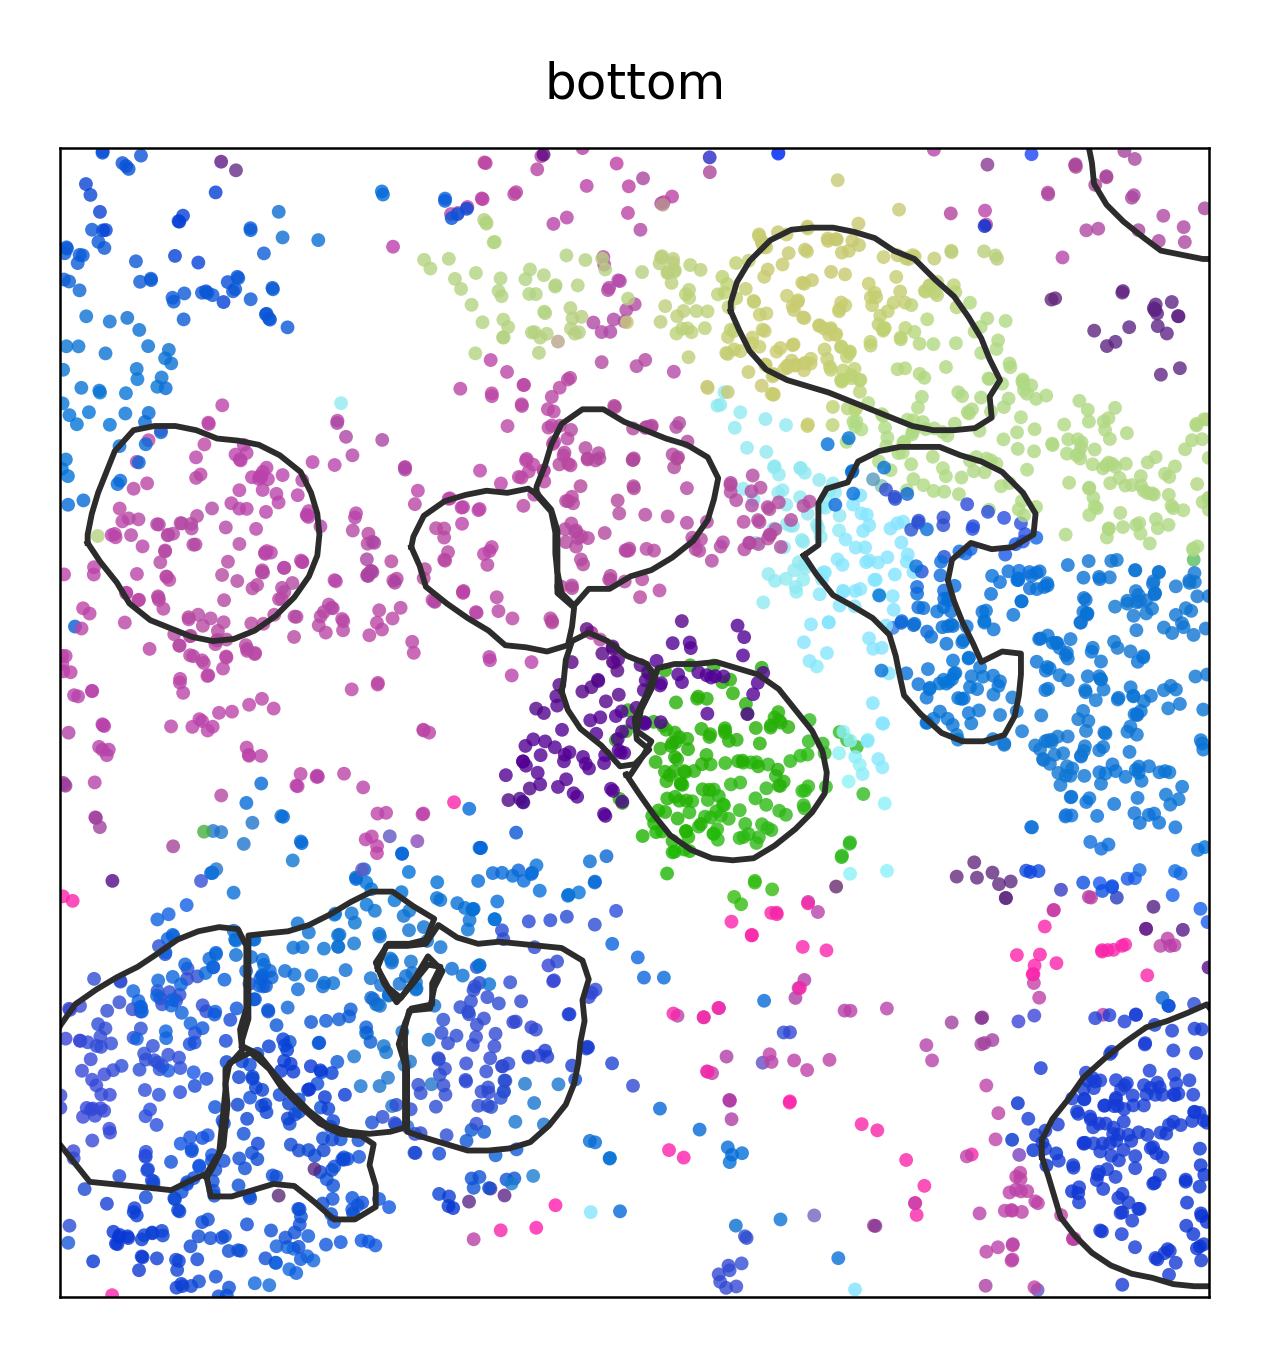

In [45]:
scalebar = SCALEBAR_PARAMS


roi_scatter_kwargs = dict(marker=".", alpha=0.8, s=11)

roi_bottom = ROI_ex.filter(pl.col("z") < pl.col("z_center"))[::-1]
fig, ax = plt.subplots(figsize=(6/2.54, 6/2.54), dpi=600)
ax.scatter(
    roi_bottom["x"],
    roi_bottom["y"],
    c=roi_bottom["RGB"].to_numpy(),
    **roi_scatter_kwargs,
    edgecolors='none',
    rasterized=True
)

# ax.scatter(x, y, c="k", marker="+", s=17)
ax.set(xlim=roi[0], ylim=roi[1])

# _plot_scalebar(ax, dx=1, units="um", location="upper right", length_fraction=0.2, fontsize=6)

x_min, x_max = roi[0]
y_min, y_max = roi[1]

filtered_df = boundaries_df[
    (boundaries_df['x'] >= x_min) & (boundaries_df['x'] <= x_max) &
    (boundaries_df['y'] >= y_min) & (boundaries_df['y'] <= y_max)
]

for _, row in filtered_df.iterrows():
    ax.plot(row['boundaryX'], row['boundaryY'],
               c='#2C2C2C', linewidth=0.7)
    ax.spines[["top", "right"]].set_visible(True)

ax.set_xticks([])
ax.set_yticks([])
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_linewidth(0.3)
ax.spines['right'].set_linewidth(0.3)
ax.spines['top'].set_linewidth(0.3)
plt.title("bottom", fontsize=6)
ax.set_aspect('equal')
plt.tight_layout()  
plt.show()